## Importing the Library


In [1]:
import os
import time
seed = 1228
os.environ["PYTHONHASHSEED"] = str(seed)

# Allow non-deterministic GPU kernels (required for some gradient kernels in TF 2.10)
os.environ["TF_DETERMINISTIC_OPS"] = "0"
os.environ["TF_CUDNN_DETERMINISTIC"] = "0"

# Now import TF and set seeds
import random, numpy as np
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

print("TensorFlow version:", tf.__version__)
print("GPUs available:", tf.config.list_physical_devices('GPU'))

tf.config.set_logical_device_configuration(
    gpus[0],
    [tf.config.LogicalDeviceConfiguration(memory_limit=6000)]  # limit to 6 GB, for example
)


TensorFlow version: 2.10.0
GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
#Domain bounds
x_a, x_b = 0.0, 2.0
y_a, y_b = 0.0, 2.0
t_0, t_t = 0.0, 0.6
dx = 0.02
dy = 0.02
dt = 0.1
len_x = (x_b - x_a) / dx
len_y = (y_b - y_a) / dy
len_t = (t_t - t_0) / dt    

print("Number of grid points in x direction:", len_x)
print("Number of grid points in y direction:", len_y)
print("Number of grid points in t direction:", len_t)

# Generate grid points
X,Y,T = np.meshgrid(np.arange(x_a, x_b + dx, dx), np.arange(y_a, y_b + dy, dy), np.arange(t_0, t_t + dt, dt))
input_tensor = np.hstack((X.flatten()[:,None], Y.flatten()[:,None], T.flatten()[:,None]))
input_tensor = tf.Variable(input_tensor, dtype=tf.float32)
#masking_ic = (input_tensor[:,2] == 0) & (0.5 <= input_tensor[:,0]) & (input_tensor[:,0] <= 1.0) & (0.5 <= input_tensor[:,1]) & (input_tensor[:,1] <= 1.0)
masking_ic = (
    tf.equal(input_tensor[:, 2], 0) &
    tf.greater_equal(input_tensor[:, 0], 0.5) &
    tf.less_equal(input_tensor[:, 0], 1.0) &
    tf.greater_equal(input_tensor[:, 1], 0.5) &
    tf.less_equal(input_tensor[:, 1], 1.0)
)
left_wall = tf.equal(input_tensor[:,0], 0)
right_wall = tf.equal(input_tensor[:,0], 2.0)
bottom_wall = tf.equal(input_tensor[:,1], 0)
top_wall = tf.equal(input_tensor[:,1], 2.0)

print("Input tensor shape:", input_tensor.shape)
print("Input tensor IC shape:", input_tensor[masking_ic].shape)


Number of grid points in x direction: 100.0
Number of grid points in y direction: 100.0
Number of grid points in t direction: 5.999999999999999
Input tensor shape: (71407, 3)
Input tensor IC shape: (676, 3)


In [4]:
class PINN (tf.keras.Model):
    def __init__(self, layers, activation):
        super(PINN, self).__init__()
        
        self.x = input_tensor[:,0:1]
        self.y = input_tensor[:,1:2]
        self.t = input_tensor[:,2:3]
        self.input_tensor = input_tensor

        self.lb = tf.reduce_min(input_tensor, axis=0, keepdims=True)
        self.ub = tf.reduce_max(input_tensor, axis=0, keepdims=True)
        
        self.left_wall = left_wall
        self.right_wall = right_wall
        self.bottom_wall = bottom_wall
        self.top_wall = top_wall
        self.masking_ic = masking_ic
        self.wall = tf.logical_or(self.left_wall, tf.logical_or(self.right_wall, tf.logical_or(self.bottom_wall, self.top_wall)))
        
        self.hidden = []
        for i in range(len(layers) - 2):
            self.hidden.append(tf.keras.layers.Dense(layers[i+1], activation=activation,
                                                     kernel_initializer='glorot_normal'))
        self.out = tf.keras.layers.Dense(layers[-1], activation='linear',
                                         kernel_initializer='glorot_normal')

    def call(self, X):
        H = 2.0 * (X - self.lb) / (self.ub - self.lb) - 1.0
        for layer in self.hidden:
            H = layer(H)
        Y = self.out(H)
        return Y
    
    def net_uvp(self, x, y, t):
        with tf.GradientTape(persistent=True) as tape:
            tape.watch([x, y, t])
            u_v_t = self.call(tf.concat([x, y, t], axis=1))
            u = u_v_t[:, 0:1]
            v = u_v_t[:, 1:2]
            
        u_x = tape.gradient(u, x)
        u_y = tape.gradient(u, y)
        v_x = tape.gradient(v, x)
        v_y = tape.gradient(v, y)
        u_t = tape.gradient(u, t)
        v_t = tape.gradient(v, t)
        del tape
        return u, v, u_x, u_y, v_x, v_y, u_t, v_t
    
    def loss(self, x, y, t):
        u, v, u_x, u_y, v_x, v_y, u_t, v_t = self.net_uvp(x, y, t)
        u_init = tf.boolean_mask(u, self.masking_ic)
        v_init = tf.boolean_mask(v, self.masking_ic)
        u_wall = tf.boolean_mask(u, self.wall)
        v_wall = tf.boolean_mask(v, self.wall)

        mse_u_ic = tf.reduce_mean(tf.square(u_init - 2*tf.ones_like(u_init)))
        mse_v_ic = tf.reduce_mean(tf.square(v_init - 2*tf.ones_like(v_init)))
        mse_u_wall = tf.reduce_mean(tf.square(u_wall - tf.ones_like(u_wall)))
        mse_v_wall = tf.reduce_mean(tf.square(v_wall - tf.zeros_like(v_wall)))

        mse_uf = tf.reduce_mean(tf.square(u_t + u*u_x + v*u_y))
        mse_vf = tf.reduce_mean(tf.square(v_t + u*v_x + v*v_y))

        loss_value = mse_u_ic + mse_v_ic + mse_u_wall + mse_v_wall + mse_uf + mse_vf
        return mse_u_ic, mse_v_ic, mse_u_wall, mse_v_wall, mse_uf, mse_vf, loss_value
    
# Define the neural network architecture
layers = [3, 40, 40, 40, 2] 
activation = 'tanh'
model = PINN(layers, activation)

def train(model, input_tensor, epochs, print_interval=100):
    # Learning rate schedule
    lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
        boundaries=[1000, 25000, 50000, 100000],
        values=[1e-3, 1e-4, 4e-5, 1e-5, 5e-6]
    )
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=lr_schedule,
        beta_1=0.9, beta_2=0.999, epsilon=1e-7
    )

    # History dictionary
    loss_history = {
        "total": [],
        "u_ic": [],
        "v_ic": [],
        "u_wall": [],
        "v_wall": [],
        "uf": [],
        "vf": []
    }

    # Extract coordinates
    x = tf.reshape(input_tensor[:, 0:1], [-1, 1])
    y = tf.reshape(input_tensor[:, 1:2], [-1, 1])
    t = tf.reshape(input_tensor[:, 2:3], [-1, 1])

    # One training step (compiled for speed)
    @tf.function
    def train_step(x, y, t):
        with tf.GradientTape() as tape:
            mse_u_ic, mse_v_ic, mse_u_wall, mse_v_wall, mse_uf, mse_vf, total_loss = model.loss(x, y, t)
        gradients = tape.gradient(total_loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        return mse_u_ic, mse_v_ic, mse_u_wall, mse_v_wall, mse_uf, mse_vf, total_loss

    # Training loop
    for epoch in range(epochs + 1):
        mse_u_ic, mse_v_ic, mse_u_wall, mse_v_wall, mse_uf, mse_vf, total_loss = train_step(x, y, t)

        # Store values as Python floats
        loss_history["u_ic"].append(float(mse_u_ic))
        loss_history["v_ic"].append(float(mse_v_ic))
        loss_history["u_wall"].append(float(mse_u_wall))
        loss_history["v_wall"].append(float(mse_v_wall))
        loss_history["uf"].append(float(mse_uf))
        loss_history["vf"].append(float(mse_vf))
        loss_history["total"].append(float(total_loss))

        # Print progress every few epochs
        if epoch % print_interval == 0:
            print(
                f"Epoch {epoch:05d} | "
                f"Loss={total_loss:.4e}, "
                f"u_ic={mse_u_ic:.3e}, v_ic={mse_v_ic:.3e}, "
                f"u_w={mse_u_wall:.3e}, v_w={mse_v_wall:.3e}, "
                f"uf={mse_uf:.3e}, vf={mse_vf:.3e}"
            )

    return loss_history

# Train the model
start_time = time.time()
history = train(model, input_tensor, epochs=200000, print_interval=100)
end_time = time.time()
print(f"Training completed in {end_time - start_time:.2f} seconds.")
        

Epoch 00000 | Loss=1.0230e+01, u_ic=3.813e+00, v_ic=4.970e+00, u_w=1.021e+00, v_w=3.476e-02, uf=4.766e-02, vf=3.430e-01
Epoch 00100 | Loss=1.5346e+00, u_ic=7.670e-02, v_ic=4.884e-01, u_w=1.153e-01, v_w=7.296e-01, uf=4.357e-02, vf=8.095e-02
Epoch 00200 | Loss=5.2781e-01, u_ic=1.492e-02, v_ic=1.127e-01, u_w=3.907e-02, v_w=2.556e-01, uf=3.498e-02, vf=7.054e-02
Epoch 00300 | Loss=3.7289e-01, u_ic=1.767e-02, v_ic=7.025e-02, u_w=2.695e-02, v_w=1.203e-01, uf=3.598e-02, vf=1.017e-01
Epoch 00400 | Loss=3.2598e-01, u_ic=2.059e-02, v_ic=6.070e-02, u_w=2.558e-02, v_w=9.912e-02, uf=2.538e-02, vf=9.461e-02
Epoch 00500 | Loss=2.9589e-01, u_ic=2.059e-02, v_ic=5.510e-02, u_w=2.363e-02, v_w=8.839e-02, uf=2.143e-02, vf=8.675e-02
Epoch 00600 | Loss=2.7289e-01, u_ic=2.000e-02, v_ic=5.059e-02, u_w=2.111e-02, v_w=8.144e-02, uf=1.984e-02, vf=7.990e-02
Epoch 00700 | Loss=2.5301e-01, u_ic=1.957e-02, v_ic=4.665e-02, u_w=1.828e-02, v_w=7.567e-02, uf=1.906e-02, vf=7.377e-02
Epoch 00800 | Loss=2.3354e-01, u_ic=1.95

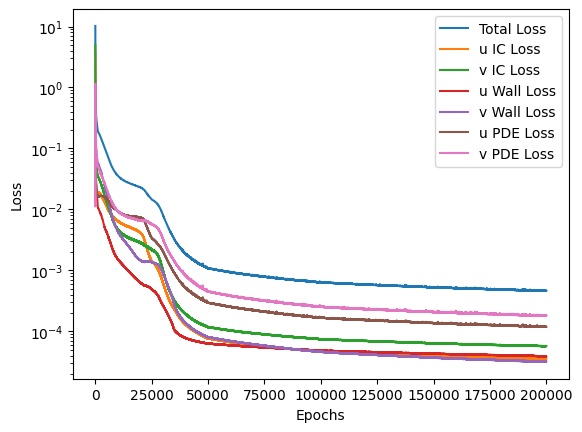

In [9]:
plt.plot(history['total'], label='Total Loss')
plt.plot(history['u_ic'], label='u IC Loss')
plt.plot(history['v_ic'], label='v IC Loss')
plt.plot(history['u_wall'], label='u Wall Loss')
plt.plot(history['v_wall'], label='v Wall Loss')
plt.plot(history['uf'], label='u PDE Loss')
plt.plot(history['vf'], label='v PDE Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale("log")
plt.legend()

input_tensor shape: (622261, 3)
first few rows:
 [[0.   0.   0.  ]
 [0.   0.   0.01]
 [0.   0.   0.02]
 [0.   0.   0.03]
 [0.   0.   0.04]]

Sanity check:
input_tensor[0] -> [0. 0. 0.]
input_tensor[Nx*Ny] -> [1.32 0.02 0.14]


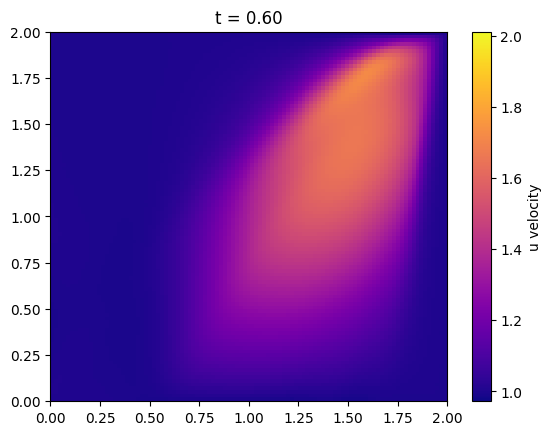

In [5]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

x_a, x_b, dx = 0.0, 2.0, 0.02
y_a, y_b, dy = 0.0, 2.0, 0.02
t_0, t_t, dt = 0.0, 0.6, 0.01

x = np.arange(x_a, x_b + dx, dx)
y = np.arange(y_a, y_b + dy, dy)
t = np.arange(t_0, t_t + dt, dt)

Nx, Ny, Nt = len(x), len(y), len(t)

X_list, Y_list, T_list = [], [], []
for ti in t:
    X, Y = np.meshgrid(x, y, indexing='xy')
    X_list.append(X)
    Y_list.append(Y)
    T_list.append(np.full_like(X, ti))

X = np.stack(X_list, axis=-1)  # shape (Ny, Nx, Nt)
Y = np.stack(Y_list, axis=-1)
T = np.stack(T_list, axis=-1)

input_tensor = np.hstack((
    X.flatten()[:, None],
    Y.flatten()[:, None],
    T.flatten()[:, None]
)).astype(np.float32)

input_tensor = tf.Variable(input_tensor, dtype=tf.float32)

print(f"input_tensor shape: {input_tensor.shape}")
print("first few rows:\n", input_tensor[:5].numpy())

u_v_pred = model(input_tensor)
u_pred = u_v_pred[:, 0:1].numpy()
v_pred = u_v_pred[:, 1:2].numpy()

u_pred = u_pred.reshape(Ny, Nx, Nt, order='C')
v_pred = v_pred.reshape(Ny, Nx, Nt, order='C')


print("\nSanity check:")
print("input_tensor[0] ->", input_tensor[0].numpy())            # (x_a, y_a, t_0)
print("input_tensor[Nx*Ny] ->", input_tensor[Nx*Ny].numpy())    # (x_a, y_a, t_0+dt)

fig, ax = plt.subplots()
cax = ax.imshow(u_pred[:, :, 0], origin='lower', cmap='plasma',
                extent=[x_a, x_b, y_a, y_b], aspect='auto')
fig.colorbar(cax, label='u velocity')

def animate(i):
    cax.set_data(u_pred[:, :, i])
    ax.set_title(f"t = {t_0 + i * dt:.2f}")
    return [cax]

ani = animation.FuncAnimation(fig, animate, frames=Nt, interval=200, blit=True)

# Show animation inline in Jupyter
HTML(ani.to_jshtml())
